###Note: this tutorial needs updating and has not been recently tested for basic functionality: use at own risk

In [1]:
import os
import sys
import time
import json

import pygsti

#The following two lines should be changed to reflect your own paths to GST/src and GSTData/data/Ion_Trap_SNL/2015_03_30/GST_BB1_XX_512_condensed.txt 
#sys.path.append('/Users/kmrudin/GST/src/')
#dataFile = '/Users/kmrudin/GSTData/data/Ion_Trap_SNL/2015_03_30/GST_BB1_XX_512_condensed.txt'
#import Bootstrap
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Load example quantities from files
gs_target = pygsti.io.load_gateset("tutorial_files/Example_Gateset.txt")
gs_mc2gst = pygsti.io.load_gateset("tutorial_files/Example_MC2GST_Gateset.txt")

ds = pygsti.io.load_dataset("tutorial_files/Example_Dataset.txt", cache=True)

fiducials = pygsti.io.load_gatestring_list("tutorial_files/Example_FiducialList.txt")
germs = pygsti.io.load_gatestring_list("tutorial_files/Example_GermsList.txt")
maxLengths = json.load(open("tutorial_files/Example_maxLengths.json","r"))

specs = pygsti.construction.build_spam_specs(fiducials)

Loading from cache file:  tutorial_files/Example_Dataset.txt.cache


##Parametric Bootstrapping
Here we do parametric bootstrapping, as indicated by the 'parametric' argument below.
The output is eventually stored in the "mean" and "std" GateSets, which hold the mean and standard deviation values of the set of bootstrapped gatesets (after gauge optimization).  It is this latter "standard deviation Gateset"
which holds the collection of error bars.  Note: due to print setting issues, the outputs that are printed here will not necessarily reflect the true accuracy of the estimates made.


In [3]:
#The number of simulated datasets & gatesets made for bootstrapping purposes.  
# For good statistics, should probably be greater than 10.
numGatesets=10

param_boot_gatesets = pygsti.drivers.make_bootstrap_gatesets(
                        numGatesets, ds, 'parametric', fiducials, fiducials, germs, maxLengths,
                        inputGateSet=gs_mc2gst, startSeed=0, constrainToTP=True, returnData=False,
                        verbosity=2)

Creating DataSets: 
0  Generating parametric dataset.
1  Generating parametric dataset.
2  Generating parametric dataset.
3  Generating parametric dataset.
4  Generating parametric dataset.
5  Generating parametric dataset.
6  Generating parametric dataset.
7  Generating parametric dataset.
8  Generating parametric dataset.
9  Generating parametric dataset.
Creating GateSets: 
Running MLGST Iteration 0 
LGST: Singular values of I_tilde (truncating to first 4 of 6) = 
[ 4.24398536  1.19629118  0.97626973  0.92032344  0.08003613  0.01407496]

--- LGST ---

--- Gauge Optimization to TP (L-BFGS-B) ---
   44s           0.0076147219
   44s           0.0040626408
   44s           0.0015977696
   44s           0.0002658189
   44s           0.0000074511
   44s           0.0000004158
   44s           0.0000000823
   44s           0.0000000469
   44s           0.0000000468
The resulting TP penalty is: 4.68406e-08
The gauge matrix found (B^-1) is:
[[  1.15008201e+00  -1.48657882e-03  -2.98965618e-

Spam weight  0
Spam weight  1
Spam weight  2
Spam weight  3
Spam weight  4
Spam weight  5
Spam weight  6
Spam weight  7
Spam weight  8
Spam weight  9
Spam weight  10
Spam weight  11
Spam weight  12
Best SPAM weight is 1.0


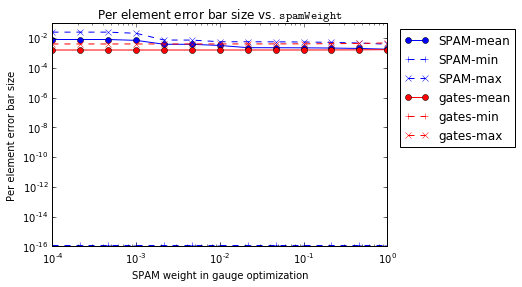

In [4]:
gauge_opt_pboot_gatesets = pygsti.drivers.gauge_optimize_gs_list(param_boot_gatesets, gs_mc2gst,
                                                                 constrainToTP=True, plot=True)

In [6]:
pboot_mean = pygsti.drivers.to_mean_gateset(gauge_opt_pboot_gatesets, gs_mc2gst)
pboot_std  = pygsti.drivers.to_std_gateset(gauge_opt_pboot_gatesets, gs_mc2gst)

#Summary of the error bars
print "Parametric bootstrapped error bars, with",numGatesets,"resamples\n"
print "Error in rho vec:" 
print pboot_std.rhoVecs[0]
print
print "Error in E vec:"
print pboot_std.EVecs[0]
print
print "Error in Gi:"
print pboot_std['Gi']
print
print "Error in Gx:"
print pboot_std['Gx']
print
print "Error in Gy:"
print pboot_std['Gy']

 Parametric bootstrapped error bars, with 10 resamples

Error in rho vec:
[[  1.17027782e-16]
 [  3.89810443e-03]
 [  2.76108647e-03]
 [  2.86059502e-04]]

Error in E vec:
[[ 0.0003536 ]
 [ 0.00298662]
 [ 0.00389878]
 [ 0.00030908]]

Error in Gi:
[[ 0.          0.          0.          0.        ]
 [ 0.00056446  0.00299186  0.00346371  0.00397397]
 [ 0.00055001  0.0031167   0.00215489  0.00390212]
 [ 0.00043662  0.00252196  0.00207141  0.00263584]]

Error in Gx:
[[ 0.          0.          0.          0.        ]
 [ 0.00055667  0.00273887  0.00351836  0.00230334]
 [ 0.00111585  0.00300194  0.00335682  0.00147985]
 [ 0.00085498  0.00240279  0.00151616  0.00190966]]

Error in Gy:
[[ 0.          0.          0.          0.        ]
 [ 0.00159497  0.00477895  0.0030408   0.00152758]
 [ 0.00049893  0.00183629  0.00332884  0.00339016]
 [ 0.00125118  0.00155437  0.0030288   0.00193707]]


##Non-parametric Bootstrapping
Here we do non-parametric bootstrapping, as indicated by the 'nonparametric' argument below.
The output is again eventually stored in the "mean" and "std" GateSets, which hold the mean and standard deviation values of the set of bootstrapped gatesets (after gauge optimization).  It is this latter "standard deviation Gateset"
which holds the collection of error bars.  Note: due to print setting issues, the outputs that are printed here will not necessarily reflect the true accuracy of the estimates made.

(Technical note: ddof = 1 is by default used when computing the standard deviation -- see numpy.std -- meaning that we are computing a standard deviation of the sample, not of the population.)

In [7]:
#The number of simulated datasets & gatesets made for bootstrapping purposes.  
# For good statistics, should probably be greater than 10.
numGatesets=10

nonparam_boot_gatesets = pygsti.drivers.make_bootstrap_gatesets(
                          numGatesets, ds, 'nonparametric', fiducials, fiducials, germs, maxLengths,
                          targetGateSet=gs_mc2gst, startSeed=0, constrainToTP=True, returnData=False,
                          verbosity=2)

Creating DataSets: 
0  Generating non-parametric dataset.
1  Generating non-parametric dataset.
2  Generating non-parametric dataset.
3  Generating non-parametric dataset.
4  Generating non-parametric dataset.
5  Generating non-parametric dataset.
6  Generating non-parametric dataset.
7  Generating non-parametric dataset.
8  Generating non-parametric dataset.
9  Generating non-parametric dataset.
Creating GateSets: 
Running MLGST Iteration 0 
LGST: Singular values of I_tilde (truncating to first 4 of 6) = 
[ 4.24456639  1.20003951  0.98516344  0.91779559  0.03726084  0.01213483]

--- LGST ---

--- Gauge Optimization to TP (L-BFGS-B) ---
  939s           0.0076712320
  939s           0.0040413435
  939s           0.0015620716
  939s           0.0002570980
  939s           0.0000098219
  939s           0.0000007384
  939s           0.0000002003
  939s           0.0000001976
The resulting TP penalty is: 1.97603e-07
The gauge matrix found (B^-1) is:
[[  1.15001433e+00  -1.55670238e-03  -2.

Spam weight  0
Spam weight  1
Spam weight  2
Spam weight  3
Spam weight  4
Spam weight  5
Spam weight  6
Spam weight  7
Spam weight  8
Spam weight  9
Spam weight  10
Spam weight  11
Spam weight  12
Best SPAM weight is 1.0


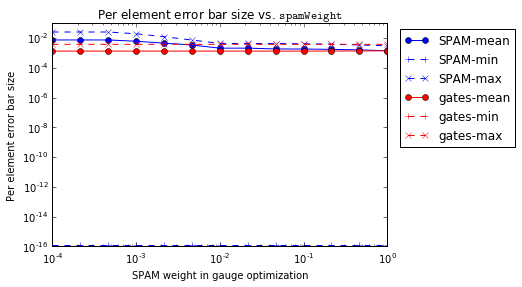

In [8]:
gauge_opt_npboot_gatesets = pygsti.drivers.gauge_optimize_gs_list(nonparam_boot_gatesets, gs_mc2gst,
                                                                 constrainToTP=True, plot=True)

In [9]:
npboot_mean = pygsti.drivers.to_mean_gateset(gauge_opt_npboot_gatesets, gs_mc2gst)
npboot_std  = pygsti.drivers.to_std_gateset(gauge_opt_npboot_gatesets, gs_mc2gst)

#Summary of the error bars
print "Non-parametric bootstrapped error bars, with",numGatesets,"resamples\n"
print "Error in rho vec:" 
print npboot_std.rhoVecs[0]
print
print "Error in E vec:"
print npboot_std.EVecs[0]
print
print "Error in Gi:"
print npboot_std['Gi']
print
print "Error in Gx:"
print npboot_std['Gx']
print
print "Error in Gy:"
print npboot_std['Gy']

Non-parametric bootstrapped error bars, with 10 resamples

Error in rho vec:
[[  1.17027782e-16]
 [  1.99738104e-03]
 [  2.79844232e-03]
 [  1.90448157e-04]]

Error in E vec:
[[ 0.00041479]
 [ 0.00306108]
 [ 0.00266744]
 [ 0.0002764 ]]

Error in Gi:
[[ 0.          0.          0.          0.        ]
 [ 0.00064338  0.00222999  0.00350751  0.00384113]
 [ 0.00054401  0.00258955  0.0014322   0.00261458]
 [ 0.00039303  0.00234993  0.00164841  0.00262405]]

Error in Gx:
[[ 0.          0.          0.          0.        ]
 [ 0.00047712  0.00220532  0.00373996  0.0021974 ]
 [ 0.00103899  0.0028076   0.00268864  0.00135054]
 [ 0.00120535  0.00151766  0.00147284  0.00166546]]

Error in Gy:
[[ 0.          0.          0.          0.        ]
 [ 0.0008808   0.00265367  0.00258749  0.00128926]
 [ 0.00047863  0.00190443  0.00281074  0.0024489 ]
 [ 0.00072845  0.00145286  0.00242723  0.00197883]]


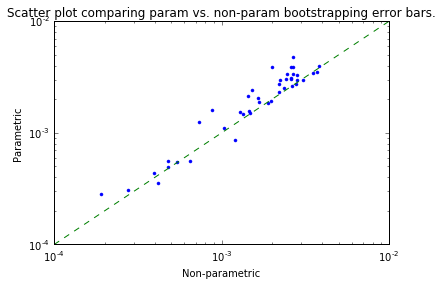

In [15]:
loglog(npboot_std.to_vector(),pboot_std.to_vector(),'.')
loglog(np.logspace(-4,-2,10),np.logspace(-4,-2,10),'--')
xlabel('Non-parametric')
ylabel('Parametric')
xlim((1e-4,1e-2)); ylim((1e-4,1e-2))
title('Scatter plot comparing param vs. non-param bootstrapping error bars.')